In [1]:
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterstats import zonal_stats

# Use rasterio to open the raster data
src = rasterio.open('../wc2.1_2.5m/cdmx_wc2.1_2.5m_prec_CNRM-CM6-1_ssp585_2021-2040.tif')


# Use geopandas to open Mexico City shp
cdmx = gpd.read_file("../datos/09mun.geojson")
#cdmx = cdmx.to_crs(4326)
cdmx = cdmx.to_crs({'init': 'epsg:4326'})


/home/milo/anaconda3/envs/geopython/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


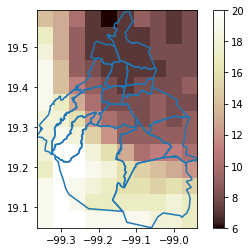

In [2]:

from rasterio.plot import show

fig, ax = plt.subplots()

# transform rasterio plot to real world coords
extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
im = ax.get_images()[0]
fig.colorbar(im, ax=ax)

cdmx.boundary.plot(ax=ax)
plt.show()


In [3]:
# Cargamos geometrías de agebs de la Zona Metropolitana del Valle de México
zmvm = gpd.read_file("https://github.com/milocortes/crecimiento_urbano/raw/main/datos/agebs_ZM_del_Valle_de_Mexico_2020.geojson")

<AxesSubplot:>

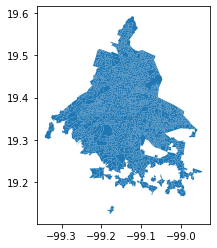

In [4]:
# Nos quedamos sólo con los registros de la Ciudad de México
cdmx_agebs = zmvm.query("CVE_ENT=='09'")
cdmx_agebs.plot()

/home/milo/anaconda3/envs/geopython/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

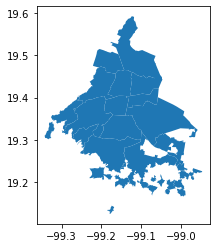

In [5]:
# Hacemos un dissolve para agregar las geometrías de agebs a localidades
cdmx_agebs["CVEGEO_LOC"] = cdmx_agebs["CVEGEO"].apply(lambda x: x[:9])
cdmx_loc = cdmx_agebs[["CVEGEO_LOC","geometry"]].dissolve("CVEGEO_LOC")
cdmx_loc.plot()

In [6]:
# Obtenemos el valor de precipitación de para cada ageb a partir del raster cdmx_wc2.1_2.5m_prec_CNRM-CM6-1_ssp585_2021-2040.tif

cdmx_agebs_prec = zonal_stats(
        vectors=cdmx_agebs["geometry"],
        raster='../wc2.1_2.5m/cdmx_wc2.1_2.5m_prec_CNRM-CM6-1_ssp585_2021-2040.tif',
        stats='mean', all_touched=True
    )

cdmx_agebs["prec"] = [v for prec in cdmx_agebs_prec for k,v in prec.items()]


/home/milo/anaconda3/envs/geopython/lib/python3.7/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


<AxesSubplot:>

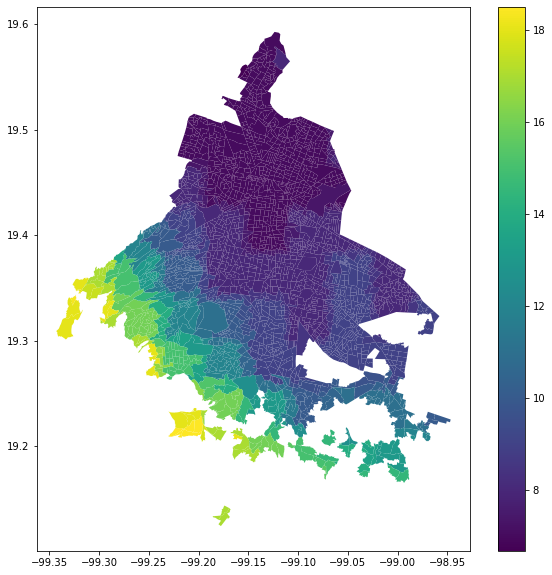

In [7]:
cdmx_agebs.plot(column ="prec", legend=True,figsize=(10, 10)) 

## Cargamos geometría de las colonias de la CDMX

In [8]:
cdmx_col = gpd.read_file("../datos/09_colonias_todo.geojson")

In [9]:
cdmx_col_prec = zonal_stats(
        vectors=cdmx_col["geometry"],
        raster='../wc2.1_2.5m/cdmx_wc2.1_2.5m_prec_CNRM-CM6-1_ssp585_2021-2040.tif',
        stats='mean', all_touched=True
    )

cdmx_col["prec"] = [v for prec in cdmx_col_prec for k,v in prec.items()]


<AxesSubplot:>

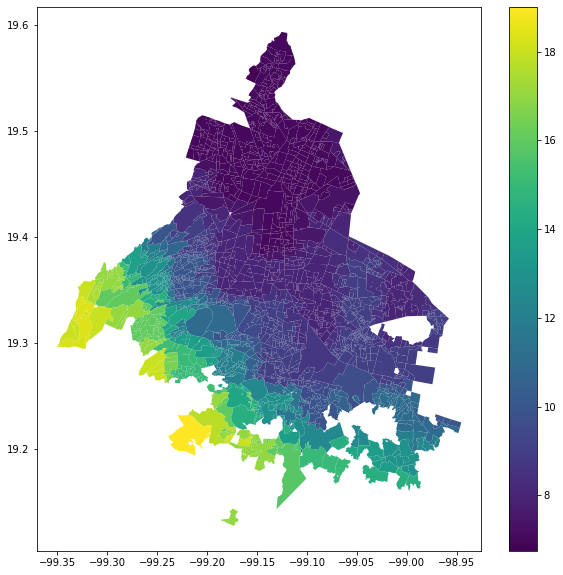

In [10]:
cdmx_col.plot(column ="prec", legend=True,figsize=(10, 10)) 

## LISA

In [11]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas as gpd  # Spatial data manipulation
import pandas  as pd# Tabular data manipulation
#import rioxarray  # Surface data manipulation
#import xarray  # Surface data manipulation
import esda  # Exploratory Spatial analytics
from libpysal import weights  # Spatial weights
import contextily  # Background tiles

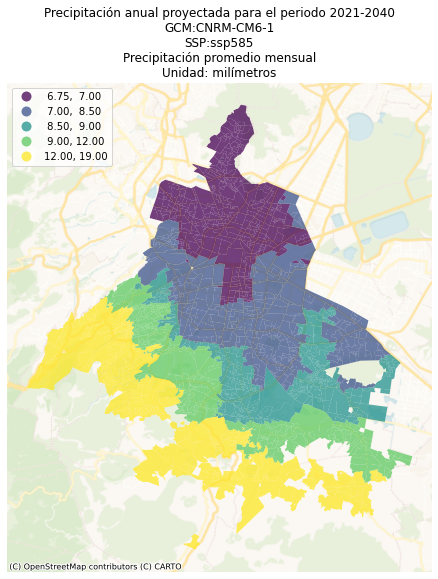

In [12]:

# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
cdmx_col.plot(
    column="prec",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=cdmx_col.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
plt.title("Precipitación anual proyectada para el periodo 2021-2040\nGCM:CNRM-CM6-1\nSSP:ssp585\nPrecipitación promedio mensual\nUnidad: milímetros")
# Remove axes
ax.set_axis_off();


In [13]:

# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(cdmx_col, k=8)
# Row-standardization
w.transform = "R"

# variables rezagadas para población total
cdmx_col["w_prec"] = weights.spatial_lag.lag_spatial(
    w, cdmx_col["prec"]
)

cdmx_col["w_prec_std"] = cdmx_col["w_prec"] - cdmx_col["w_prec"].mean()
cdmx_col["prec_std"] = cdmx_col["prec"] - cdmx_col["prec"].mean()



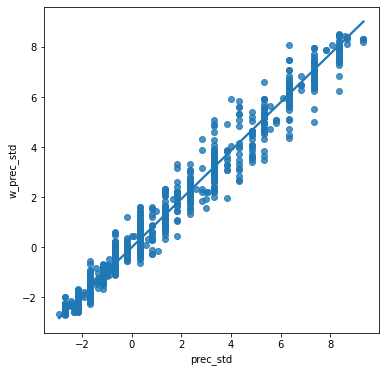

In [14]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="prec_std", y="w_prec_std", data=cdmx_col, ci=None
);


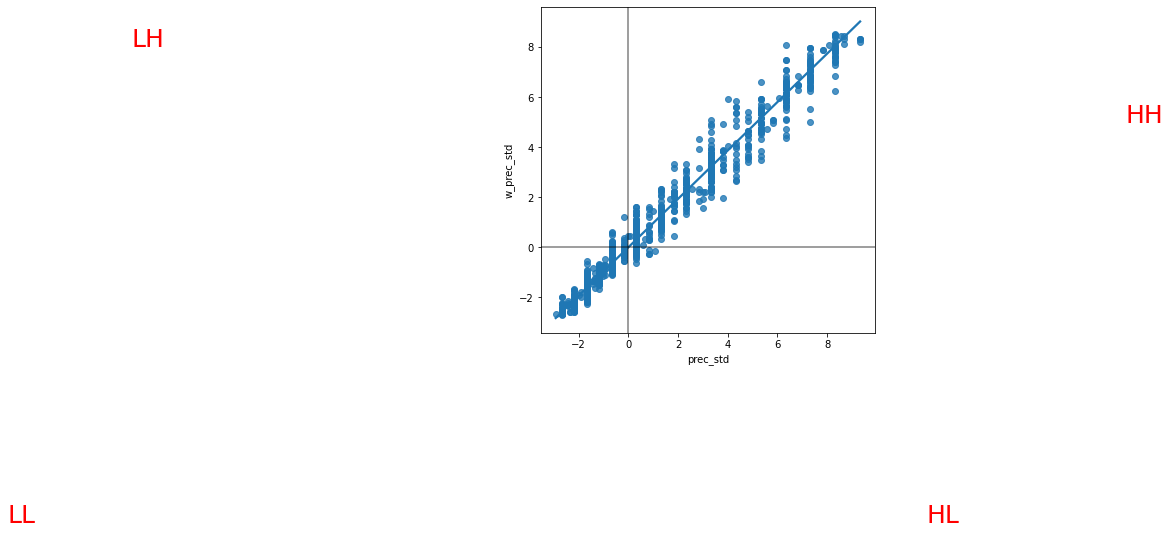

In [15]:

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="prec_std", y="w_prec_std", data=cdmx_col, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

lisa = esda.moran.Moran_Local(cdmx_col["prec"], w)


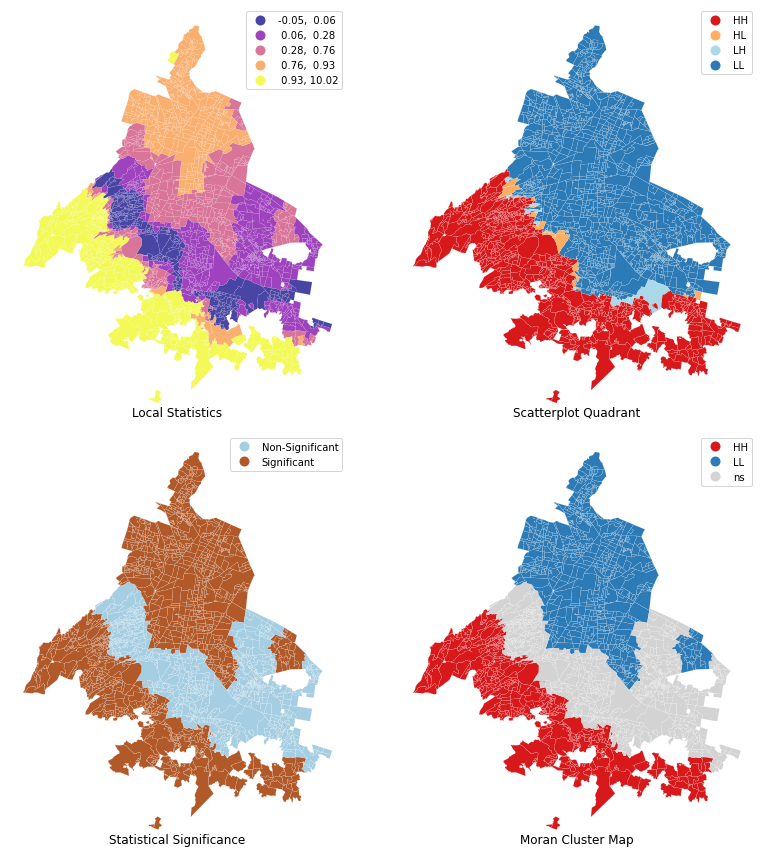

In [16]:

from splot import esda as esdaplot

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
cdmx_col.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, cdmx_col, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=cdmx_col.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
cdmx_col.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, cdmx_col, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()


In [17]:
"""
The correspondence between the numbers in the q attribute and the actual quadrants is as follows: 
    1 represents observations in the HH quadrant, 
    2 those in the LH one, 
    3 in the LL region, 
    and 4 in the HL quadrant. 
"""
lisa.q

cdmx_col["prec_lisa"] = lisa.q
cdmx_col
#zmvm.to_csv("zmvm_lisa.csv", index = False)


,OBJECTID,CVE_COL,ID_COL,COLONIA,CP,CVE_ENT,NOM_ENT,MUN,CVE_MUN,NOM_MUN,...,IM_2020,GM_2020,IMN_2020,CLASIF,geometry,prec,w_prec,w_prec_std,prec_std,prec_lisa
0,16974,09002_0001,16974,Aguilera,2900,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,151.566511,Bajo,0.966328,Colonia,"POLYGON ((-99.15266 19.47330, -99.15267 19.473...",7.000000,7.000000,-2.657467,-2.672871,3
1,16975,09002_0002,16975,Aldana,2910,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,151.301348,Bajo,0.964637,Colonia,"POLYGON ((-99.14590 19.47322, -99.14586 19.473...",7.000000,7.000000,-2.657467,-2.672871,3
2,16976,09002_0003,16976,Ampliacion del Gas,2970,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,152.551598,Muy bajo,0.972608,Colonia,"POLYGON ((-99.15415 19.46833, -99.15454 19.466...",7.000000,7.000000,-2.657467,-2.672871,3
3,16977,09002_0004,16977,Ampliacion Petrolera,2470,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,151.562971,Bajo,0.966305,Colonia,"POLYGON ((-99.19637 19.48512, -99.19586 19.484...",7.000000,7.000000,-2.657467,-2.672871,3
4,16978,09002_0005,16978,Ampliacion San Pedro Xalpa,2719,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,149.728324,Medio,0.954608,Colonia,"POLYGON ((-99.21564 19.48394, -99.21535 19.483...",7.000000,7.062500,-2.594967,-2.672871,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,100565,09017_0077,100565,Cuatro Arboles,15730,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,153.150192,Muy bajo,0.976424,Colonia,"POLYGON ((-99.08219 19.41959, -99.08225 19.419...",8.000000,7.937500,-1.719967,-1.672871,3
2239,100567,09017_0078,100567,El Arenal 1A Seccion,15600,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,149.333198,Medio,0.952089,Colonia,"POLYGON ((-99.05822 19.42669, -99.05796 19.426...",7.500000,7.750000,-1.907467,-2.172871,3
2240,100568,09017_0079,100568,Jardin Balbuena,15900,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,152.734385,Muy bajo,0.973773,Colonia,"MULTIPOLYGON (((-99.11038 19.40820, -99.11037 ...",7.333333,7.072917,-2.584550,-2.339538,3
2241,100569,09017_0080,100569,Morelos,15270,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,149.623126,Medio,0.953937,Colonia,"MULTIPOLYGON (((-99.11855 19.43879, -99.11886 ...",7.000000,7.000000,-2.657467,-2.672871,3


In [18]:
# definimos una función para hacer todo lo anterior
def lisa_categorias(nombre_columna):
    # Generate W from the GeoDataFrame
    w = weights.distance.KNN.from_dataframe(cdmx_col, k=8)
    # Row-standardization
    w.transform = "R"

    # variables rezagadas para población total
    cdmx_col[f"w_{nombre_columna}"] = weights.spatial_lag.lag_spatial(
        w, cdmx_col[nombre_columna]
    )

    cdmx_col[f"w_{nombre_columna}_std"] = cdmx_col[f"w_{nombre_columna}"] - cdmx_col[f"w_{nombre_columna}"].mean()
    cdmx_col[f"{nombre_columna}_std"] = cdmx_col[f"{nombre_columna}"] - cdmx_col[f"{nombre_columna}"].mean()

    lisa = esda.moran.Moran_Local(cdmx_col[nombre_columna], w)
    

    # Set up figure and axes
    f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
    # Make the axes accessible with single indexing
    axs = axs.flatten()

    # Subplot 1 #
    # Choropleth of local statistics
    # Grab first axis in the figure
    ax = axs[0]
    # Assign new column with local statistics on-the-fly
    cdmx_col.assign(
        Is=lisa.Is
        # Plot choropleth of local statistics
    ).plot(
        column="Is",
        cmap="plasma",
        scheme="quantiles",
        k=5,
        edgecolor="white",
        linewidth=0.1,
        alpha=0.75,
        legend=True,
        ax=ax,
    )

    # Subplot 2 #
    # Quadrant categories
    # Grab second axis of local statistics
    ax = axs[1]
    # Plot Quandrant colors (note to ensure all polygons are assigned a
    # quadrant, we "trick" the function by setting significance level to
    # 1 so all observations are treated as "significant" and thus assigned
    # a quadrant color
    esdaplot.lisa_cluster(lisa, cdmx_col, p=1, ax=ax)

    # Subplot 3 #
    # Significance map
    # Grab third axis of local statistics
    ax = axs[2]
    #
    # Find out significant observations
    labels = pd.Series(
        1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
        index=cdmx_col.index  # Use the index in the original data
        # Recode 1 to "Significant and 0 to "Non-significant"
    ).map({1: "Significant", 0: "Non-Significant"})
    # Assign labels to `db` on the fly
    cdmx_col.assign(
        cl=labels
        # Plot choropleth of (non-)significant areas
    ).plot(
        column="cl",
        categorical=True,
        k=2,
        cmap="Paired",
        linewidth=0.1,
        edgecolor="white",
        legend=True,
        ax=ax,
    )


    # Subplot 4 #
    # Cluster map
    # Grab second axis of local statistics
    ax = axs[3]
    # Plot Quandrant colors In this case, we use a 5% significance
    # level to select polygons as part of statistically significant
    # clusters
    esdaplot.lisa_cluster(lisa, cdmx_col, p=0.05, ax=ax)

    # Figure styling #
    # Set title to each subplot
    for i, ax in enumerate(axs.flatten()):
        ax.set_axis_off()
        ax.set_title(
            [
                "Local Statistics",
                "Scatterplot Quadrant",
                "Statistical Significance",
                "Moran Cluster Map",
            ][i],
            y=0,
        )
    # Tight layout to minimise in-betwee white space
    f.tight_layout()

    # Display the figure
    plt.show()
    
    cdmx_col[f"{nombre_columna}_lisa"] = lisa.q


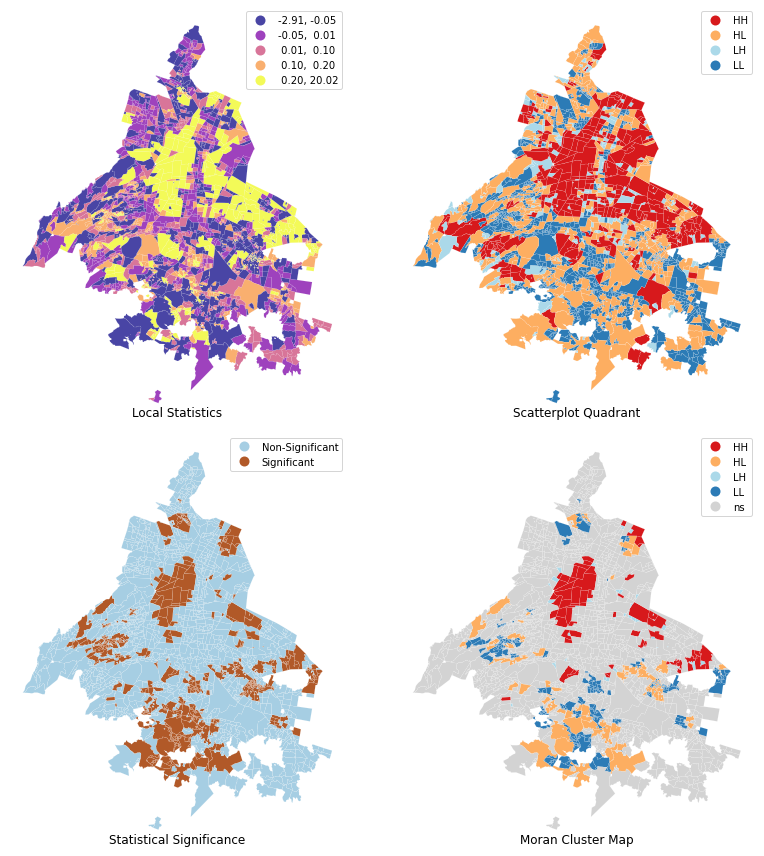

In [19]:
lisa_categorias("POBTOT")

In [20]:
import pandas as pd

cdmx_col_csv = pd.read_csv("/home/milo/Downloads/final_colonias.csv")
cdmx_col_csv.drop(columns = ['Unnamed: 0'], inplace = True)

In [21]:
cdmx_col_csv

,ID_COL,manzanas_totales_por_colonia,ABEGS_totales_por_colonia,poblacion_total.x,poblacion_total.y,viviendas_particulares_habitadas,numero_vialidades_pavimento,porcentaje_vialidades_pavimento,numero_vialidades_sin_recubrimiento,porcentaje_vialidades_sin_recubrimiento,...,porcentaje_viviendas_cisterna,viviendas_excusado,porcentaje_viviendas_excusado,viviendas_drenaje,porcentaje_viviendas_drenaje,viviendas_con_3,porcentaje_con_3,viviendas_sin_3,porcentaje_viviendas_sin_3,viviendas_agua_drenaje
0,16974,10485,16725,1674890,4307720,510295,510295,99.95,270,0.05,...,56.31,1331845,89.47,1333605,89.59,1305,0.09,1331760,89.46,4705
1,16975,20052,28925,3058631,7494484,910157,910157,99.91,775,0.09,...,53.68,2269424,90.10,2272306,90.21,2208,0.09,2269182,90.09,9266
2,16976,6585,9624,1165025,2787984,380946,380946,99.97,113,0.03,...,63.68,913110,87.85,914333,87.97,825,0.08,913026,87.84,3369
3,16977,8388,13380,1339912,3446176,408236,408236,99.95,216,0.05,...,56.31,1065476,89.47,1066884,89.59,1044,0.09,1065408,89.46,3764
4,16978,12582,20070,2009868,5169264,612354,612354,99.95,324,0.05,...,56.31,1598214,89.47,1600326,89.59,1566,0.09,1598112,89.46,5646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,100565,5730,7440,792036,1769104,238128,238128,99.97,72,0.03,...,70.54,538670,89.22,539230,89.31,678,0.11,538510,89.19,2484
2239,100567,25785,33480,3564162,7960968,1071576,1071576,99.97,324,0.03,...,70.54,2424015,89.22,2426535,89.31,3051,0.11,2423295,89.19,11178
2240,100568,42975,55800,5940270,13268280,1785960,1785960,99.97,540,0.03,...,70.54,4040025,89.22,4044225,89.31,5085,0.11,4038825,89.19,18630
2241,100569,2865,3720,396018,884552,119064,119064,99.97,36,0.03,...,70.54,269335,89.22,269615,89.31,339,0.11,269255,89.19,1242


In [22]:
cdmx_col = cdmx_col.merge(right = cdmx_col_csv, how = "inner", on = "ID_COL")
cdmx_col

,OBJECTID,CVE_COL,ID_COL,COLONIA,CP,CVE_ENT,NOM_ENT,MUN,CVE_MUN,NOM_MUN,...,porcentaje_viviendas_cisterna,viviendas_excusado,porcentaje_viviendas_excusado,viviendas_drenaje,porcentaje_viviendas_drenaje,viviendas_con_3,porcentaje_con_3,viviendas_sin_3,porcentaje_viviendas_sin_3,viviendas_agua_drenaje
0,16974,09002_0001,16974,Aguilera,2900,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,56.31,1331845,89.47,1333605,89.59,1305,0.09,1331760,89.46,4705
1,16975,09002_0002,16975,Aldana,2910,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,53.68,2269424,90.10,2272306,90.21,2208,0.09,2269182,90.09,9266
2,16976,09002_0003,16976,Ampliacion del Gas,2970,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,63.68,913110,87.85,914333,87.97,825,0.08,913026,87.84,3369
3,16977,09002_0004,16977,Ampliacion Petrolera,2470,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,56.31,1065476,89.47,1066884,89.59,1044,0.09,1065408,89.46,3764
4,16978,09002_0005,16978,Ampliacion San Pedro Xalpa,2719,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,56.31,1598214,89.47,1600326,89.59,1566,0.09,1598112,89.46,5646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,100565,09017_0077,100565,Cuatro Arboles,15730,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,70.54,538670,89.22,539230,89.31,678,0.11,538510,89.19,2484
2239,100567,09017_0078,100567,El Arenal 1A Seccion,15600,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,70.54,2424015,89.22,2426535,89.31,3051,0.11,2423295,89.19,11178
2240,100568,09017_0079,100568,Jardin Balbuena,15900,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,70.54,4040025,89.22,4044225,89.31,5085,0.11,4038825,89.19,18630
2241,100569,09017_0080,100569,Morelos,15270,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,70.54,269335,89.22,269615,89.31,339,0.11,269255,89.19,1242


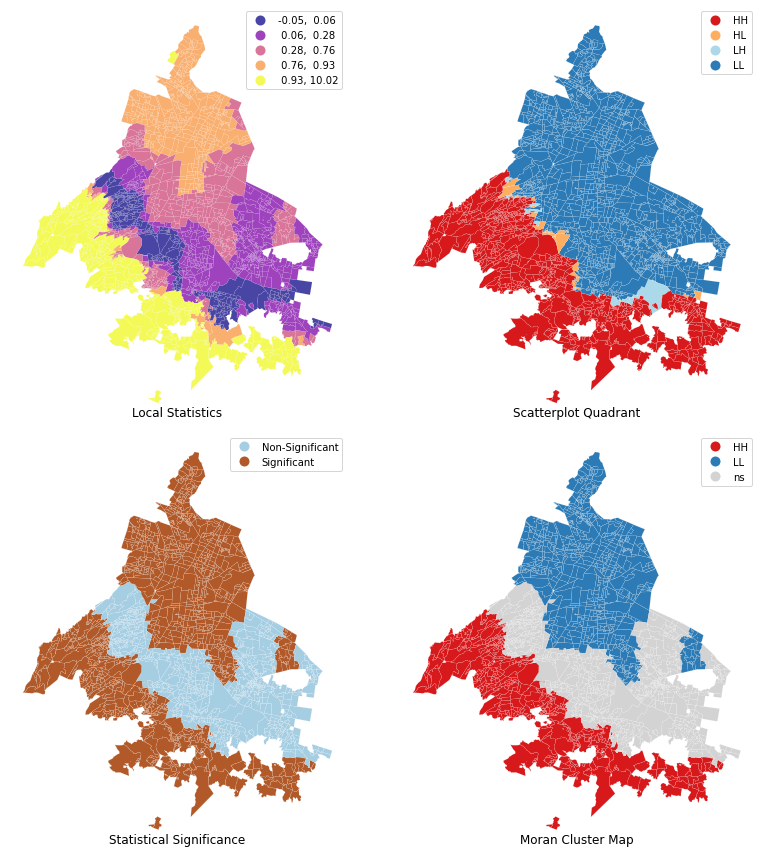

In [23]:
lisa_categorias("prec")

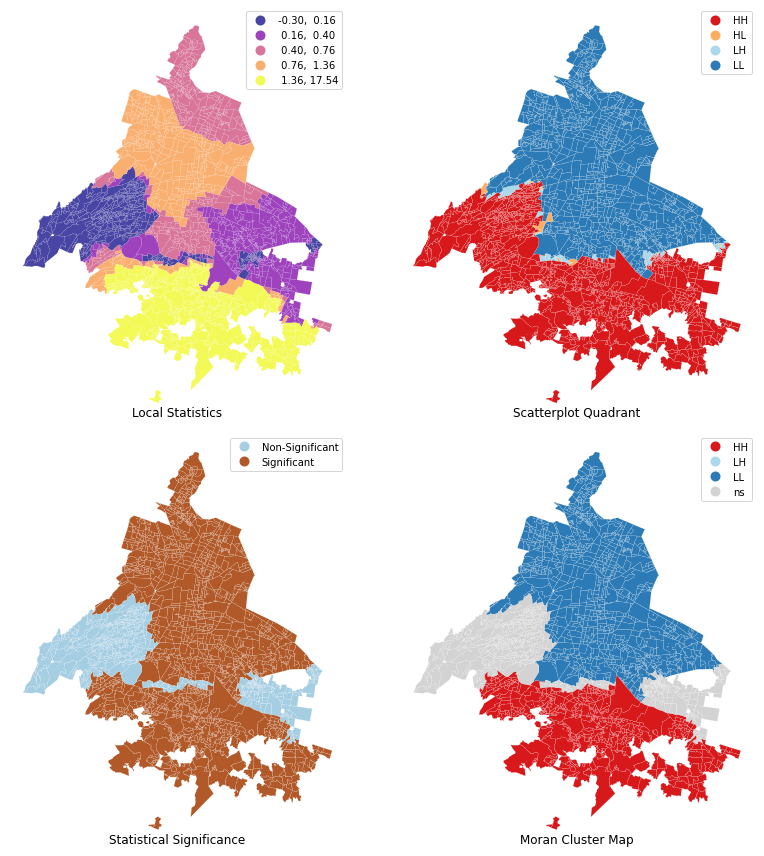

In [24]:
lisa_categorias("disponibilidad_nula_drenaje_pluvial")

In [25]:
import numpy as np

cdmx_col["colonias_objetivo"] = "NULL"
subset_index_hh = np.array([i==1 for i in cdmx_col["prec_lisa"]]) & np.array([i==1 for i in cdmx_col["disponibilidad_nula_drenaje_pluvial_lisa"]])
subset_index_ll = np.array([i==3 for i in cdmx_col["prec_lisa"]]) & np.array([i==3 for i in cdmx_col["disponibilidad_nula_drenaje_pluvial_lisa"]])

cdmx_col.loc[subset_index_hh,"colonias_objetivo"] = "HH"
cdmx_col.loc[subset_index_ll,"colonias_objetivo"] = "LL"


In [26]:
cdmx_col

,OBJECTID,CVE_COL,ID_COL,COLONIA,CP,CVE_ENT,NOM_ENT,MUN,CVE_MUN,NOM_MUN,...,viviendas_con_3,porcentaje_con_3,viviendas_sin_3,porcentaje_viviendas_sin_3,viviendas_agua_drenaje,w_disponibilidad_nula_drenaje_pluvial,w_disponibilidad_nula_drenaje_pluvial_std,disponibilidad_nula_drenaje_pluvial_std,disponibilidad_nula_drenaje_pluvial_lisa,colonias_objetivo
0,16974,09002_0001,16974,Aguilera,2900,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,1305,0.09,1331760,89.46,4705,1.95375,-17.28993,-17.778301,3,LL
1,16975,09002_0002,16975,Aldana,2910,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,2208,0.09,2269182,90.09,9266,2.68500,-16.55868,-16.028301,3,LL
2,16976,09002_0003,16976,Ampliacion del Gas,2970,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,825,0.08,913026,87.84,3369,1.57375,-17.66993,-16.688301,3,LL
3,16977,09002_0004,16977,Ampliacion Petrolera,2470,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,1044,0.09,1065408,89.46,3764,1.38000,-17.86368,-17.778301,3,LL
4,16978,09002_0005,16978,Ampliacion San Pedro Xalpa,2719,09,Ciudad de MÃ©xico,002,09002,Azcapotzalco,...,1566,0.09,1598112,89.46,5646,1.75375,-17.48993,-17.778301,3,LL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238,100565,09017_0077,100565,Cuatro Arboles,15730,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,678,0.11,538510,89.19,2484,2.55625,-16.68743,-16.738301,3,LL
2239,100567,09017_0078,100567,El Arenal 1A Seccion,15600,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,3051,0.11,2423295,89.19,11178,2.49875,-16.74493,-16.738301,3,LL
2240,100568,09017_0079,100568,Jardin Balbuena,15900,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,5085,0.11,4038825,89.19,18630,2.42750,-16.81618,-16.738301,3,LL
2241,100569,09017_0080,100569,Morelos,15270,09,Ciudad de MÃ©xico,017,09017,Venustiano Carranza,...,339,0.11,269255,89.19,1242,2.47500,-16.76868,-16.738301,3,LL


<AxesSubplot:>

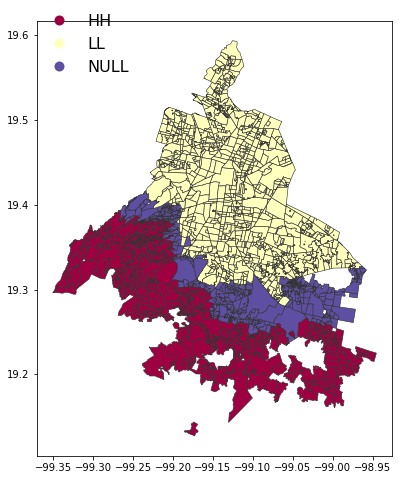

In [27]:
fig, ax = plt.subplots(1, figsize=(14,8))
cdmx_col.plot(column='colonias_objetivo', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)

In [28]:
cdmx_col["colonias_objetivo"].value_counts()

LL      1094
HH       704
NULL     445
Name: colonias_objetivo, dtype: int64

In [29]:
nombre = "orio"
print(f"Mi gato se llama {nombre}")

Mi gato se llama orio
